In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [3]:
from ast import literal_eval
train = pd.read_csv('train.csv', encoding='utf-8', converters={'clean_body': literal_eval})
test = pd.read_csv('test.csv', encoding='utf-8', converters={'clean_body': literal_eval})

In [4]:
def clean_message(message, perform_stemming = False):
    '''
    Input:
        message: a string containing a message.
    Output:
        messages_cleaned: a list of words containing the processed message. 

    '''
    #Remove Punctuation
    messages_cleaned = re.sub(r'[^\w\s]', '', message)
    
    #Remove Links
    messages_cleaned = re.sub(r'https?://\S+', '', messages_cleaned)
    
    #Lower Case
    messages_cleaned = messages_cleaned.lower()
    
    #Tokenize
    messages_cleaned = word_tokenize(messages_cleaned)
    
    #Remove Stopwords
    stop_words_list = stopwords.words('english')
    for token in messages_cleaned:
        if token in stop_words_list:
            messages_cleaned.remove(token)
    
    #Perform Stemming
    if perform_stemming == True:
        temp = messages_cleaned.copy()
        messages_cleaned.clear()
        for token in temp:
            messages_cleaned.append(PorterStemmer().stem(token))

    return messages_cleaned

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

##### Models Below

In [6]:
#importing all the libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
# Function to test models

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate(test_y, predicted_y):
    
    categories = [0,4,5,6]
    
    cm = confusion_matrix(test_y, predicted_y)
    fp = cm.sum(axis=0) - np.diag(cm) 
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    fp = fp.astype(float)
    fn = fn.astype(float)
    tp = tp.astype(float)
    tn = tn.astype(float)
    
    # Precision or positive predictive value
    precision = tp/(tp+fp)
    print('Precision: ', sum(precision)/len(categories))
    
    # Recall
    recall = tp/(tp+fn)
    print('Recall: ', sum(recall)/len(categories))
    
    # F1-Score
    F1_Score = 2*precision*recall/(precision + recall)
    print('F1-Score: ',  sum(F1_Score)/len(categories))
    
    # Sensitivity
    print('Sensitivity: ', sum(recall)/len(categories))
    
    # Specificity
    specificity = tn/(tn+fp)
    print('Specificity: ', sum(specificity)/len(categories))
    
    # Overall accuracy for each class
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    print('Accuracy: ', sum(accuracy)/len(categories))
    
    # Print Confusion Matrix
    cmd = ConfusionMatrixDisplay(cm, display_labels=categories)
    cmd.plot()
    cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [8]:
# Create X_train, X_test, y_train , y_test

X_train = pd.DataFrame(train['clean_body'])
y_train = train['category']

X_test = pd.DataFrame(test['clean_body'])
y_test =test['category']

In [9]:
X_train

,clean_body
0,"[sent, thursday, blocked, mails, hello, collea..."
1,"[wednesday, july, pm, mailbox, almost, importa..."
2,"[opportunity, code, hi, please, add, opportuni..."
3,"[thursday, pm, removal, hello, decommissioned,..."
4,"[sent, monday, timecard, hello, hours, set, au..."
...,...
96521,"[sent, wednesday, july, sensible, information,..."
96522,"[sent, wednesday, july, sensitive, information..."
96523,"[sent, wed, july, sensitive, information, acce..."
96524,"[sent, wednesday, july, sensitive, information..."


#### 1. Naive Bayes

In [10]:
class naive_bayes:
    
    def __init__(self):
        self.loglikelihood = {}
        self.logprior = {}
        self.categories = {}

    #To find frequency of a key in a dictionary
    def find_occurrence(self, frequency, word, label):
        '''
        Params:
            frequency: a dictionary with the frequency of each pair (or tuple)
            word: the word to look up
            label: the label corresponding to the word
        Return:
            n: the number of times the word with its corresponding label appears.
        '''

        if (word,label) in frequency.keys():
            n = frequency[(word,label)]
        else:
            n = 0

        return n
    
    #To create a dictionary of word and the class

    def message_counter(self, output_occurrence, messages, category):
        '''
        Params:
            output_occurrence: a dictionary that will be used to map each pair to its frequency
            messages: a list of messages
            category: a list corresponding to the category of each message (either 0,4,5,6)
        Return:
            output: a dictionary mapping each pair to its frequency
        '''
        ## Steps :
        # define the key, which is the word and label tuple
        # if the key exists in the dictionary, increment the count
        # else, if the key is new, add it to the dictionary and set the count to 1

        for message, label in zip(messages, category):
            for word in message:
                output_occurrence[(word,label)] = self.find_occurrence(output_occurrence, word, label) + 1

        return output_occurrence
    

    # Train the Naive Bayes Model
    def train_naive_bayes(self, train_x, train_y):
        '''
        Input:
            freqs: dictionary from (word, label) to how often the word appears
            train_x: a list of messages
            train_y: a list of labels correponding to the messages (0,1)
        Output:
            logprior: the log prior. (equation 3 above)
            loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
        '''

        self.categories = sorted(list(train_y.unique()))
        frequency_dict = self.message_counter({}, train_x, train_y) 

        num_words_per_class = {}

        for category in self.categories:
            self.logprior[category] = 0
            num_words_per_class[category] = 0

        # calculate V, the number of unique words in the vocabulary
        vocab = {}
        for message in train_x:
            for word in message:
                if word not in vocab.keys():
                    vocab[word] = len(vocab)
        V = len(vocab)

        #Calculate logprior for each class
        for category in self.categories:
            self.logprior[category] += np.log(len(train_y[train_y == category])/len(train_y))


        #Calculate loglikelihood for each class

        # calculate number of words in each category
        for pair in frequency_dict:
            num_words_per_class[pair[1]] += frequency_dict[pair]

        #We have to find probability of occurrence of a word, given a class
        #This is given by count(word|c)/count(count of all words|c)
        #This is also called the likelihood

        for word in vocab.keys():
            for category in self.categories:
                count = self.find_occurrence(frequency_dict, word, category)
                self.loglikelihood[(word, category)] = np.log((count + 1)/(num_words_per_class[category] + V))

        return
    
    #Implement the predict function
    def naive_bayes_predict(self, message):
        '''
        Params:
            message: a string
            logprior: a number
            loglikelihood: a dictionary of words mapping to numbers
        Return:
            total_prob: the sum of all the loglikelihoods of each word in the message (if found in the dictionary) + logprior (a number)

        '''

        # process the message to get a list of words
        word_l = clean_message(message)

        # Define a vector, that will hold values for likelihood estimates
        # Initialize the values to the prior probility
        total_prob = {}
        for category in self.categories:
            total_prob[category] = self.logprior[category]

        #Compute total probability

        for category in self.categories:
            for word in word_l:
                if (word,category) in self.loglikelihood.keys():
                    total_prob[category] += self.loglikelihood[(word, category)]

        argmax_class = max(total_prob, key = total_prob.get)

        return argmax_class

In [11]:
X_train['clean_body_w_stem'] = X_train['clean_body'].apply(lambda row: clean_message(' '.join(row), perform_stemming = True))

In [12]:
X_train

,clean_body,clean_body_w_stem
0,"[sent, thursday, blocked, mails, hello, collea...","[sent, thursday, block, mail, hello, colleagu,..."
1,"[wednesday, july, pm, mailbox, almost, importa...","[wednesday, juli, pm, mailbox, almost, import,..."
2,"[opportunity, code, hi, please, add, opportuni...","[opportun, code, hi, pleas, add, opportun, cod..."
3,"[thursday, pm, removal, hello, decommissioned,...","[thursday, pm, remov, hello, decommiss, everyt..."
4,"[sent, monday, timecard, hello, hours, set, au...","[sent, monday, timecard, hello, hour, set, aut..."
...,...,...
96521,"[sent, wednesday, july, sensible, information,...","[sent, wednesday, juli, sensibl, inform, acces..."
96522,"[sent, wednesday, july, sensitive, information...","[sent, wednesday, juli, sensit, inform, access..."
96523,"[sent, wed, july, sensitive, information, acce...","[sent, wed, juli, sensit, inform, access, hi, ..."
96524,"[sent, wednesday, july, sensitive, information...","[sent, wednesday, juli, sensit, inform, access..."


In [13]:
model = naive_bayes()
model.train_naive_bayes(X_train['clean_body_w_stem'], y_train)
print(model.logprior)
print(len(model.loglikelihood))

{0: -1.3997907434563142, 4: -1.3983636708111857, 5: -1.31125443210009, 6: -1.440248780919484}
42580


In [14]:
X_test = pd.DataFrame(X_test)
X_test['clean_body_w_stem'] = X_test['clean_body'].apply(lambda row: clean_message(' '.join(row), perform_stemming = True))
X_test['y_pred'] = X_test['clean_body_w_stem'].apply(lambda row: model.naive_bayes_predict(
    message = ' '.join(str(v) for v in row)))

Precision:  0.7316050829492688
Recall:  0.6266016375969721
F1-Score:  0.6625931661750618
Sensitivity:  0.6266016375969721
Specificity:  0.9002122963761038
Accuracy:  0.9039478201167181


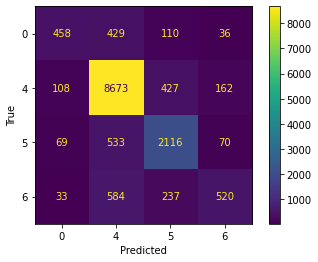

In [15]:
evaluate(X_test['y_pred'], y_test)

# Parametric Models

In [16]:
#importing all the libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
# Create X_train, X_test, y_train , y_test

X_train = pd.DataFrame(train['clean_body'])
y_train = train['category']

X_test = pd.DataFrame(test['clean_body'])
y_test =test['category']

In [18]:
X = pd.concat([X_train, X_test], axis = 0)
X

,clean_body
0,"[sent, thursday, blocked, mails, hello, collea..."
1,"[wednesday, july, pm, mailbox, almost, importa..."
2,"[opportunity, code, hi, please, add, opportuni..."
3,"[thursday, pm, removal, hello, decommissioned,..."
4,"[sent, monday, timecard, hello, hours, set, au..."
...,...
14560,"[question, job, dear, please, message, bellow,..."
14561,"[friday, pm, ad, groups, rename, hello, please..."
14562,"[updated, bandwidth, upgrade, hello, please, k..."
14563,"[wednesday, pm, questions, dear, several, ques..."


In [19]:
#Converting the sentences tokens (words) and calculating idf for every word (idf assigns weight to each word based on their occurences in documents)
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english',min_df=20,sublinear_tf=True)
tfidf_wm = tfidfvectorizer.fit_transform(X['clean_body'].apply(lambda x: ' '.join(x)))
tfidf_tokens = tfidfvectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = [i for i in range(0,len(X))],columns = tfidf_tokens)

In [87]:
#We will now use each word as a feature to predict our target variable (Category)
pd.DataFrame(df_tfidfvect.iloc[:,100:])

,ad,adapt,adaptation,adapter,adapters,adaptor,adaptors,add,added,adder,...,you,your,yourself,yr,zephyr,zero,zip,zona,zone,zones
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.143044,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111086,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.11396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111087,0.470061,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111088,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111089,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X_train = df_tfidfvect[:len(X_train)]
X_test = df_tfidfvect[len(X_train):]

#### 1. Logistic Regression

For hyp=(C=0.01), Training accuracy of Logistic Regression: 75.78683463522782%
 Test Accuracy of Logistic Regression:79.12804668726399%

Overall Model Evaluation:
Precision:  0.7248961884566222
Recall:  0.6071669516147497
F1-Score:  0.6458122085781247
Sensitivity:  0.6071669516147497
Specificity:  0.8924418164939308
Accuracy:  0.8956402334363199
For hyp=(C=0.1), Training accuracy of Logistic Regression: 82.30424963222345%
 Test Accuracy of Logistic Regression:82.6295914864401%

Overall Model Evaluation:
Precision:  0.7640644573581812
Recall:  0.6563117976777129
F1-Score:  0.6952859067407271
Sensitivity:  0.6563117976777129
Specificity:  0.9075757376394141
Accuracy:  0.9131479574322005
For hyp=(C=1), Training accuracy of Logistic Regression: 87.83332988003232%
 Test Accuracy of Logistic Regression:85.10813594232751%

Overall Model Evaluation:
Precision:  0.7803513734032939
Recall:  0.7067772902886784
F1-Score:  0.737286600883831
Sensitivity:  0.7067772902886784
Specificity:  0.918943303

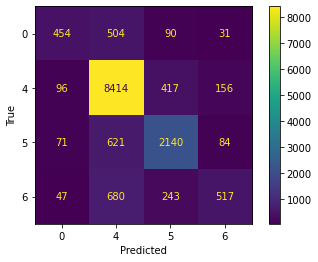

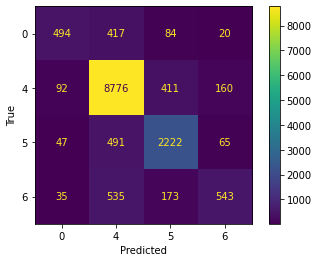

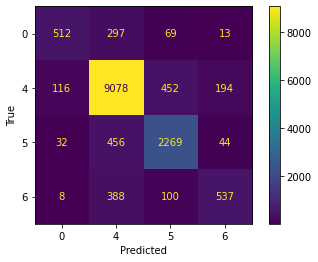

In [23]:
C= [0.01,0.1,1]         #Regularization parameter
for i in C:
  lr_clf=LogisticRegression(C=i)
  #Fitting the model
  lr_clf.fit(X_train,y_train)
  #predicting target variable for train and test data
  y_train_pred=lr_clf.predict(X_train)
  y_valid_pred=lr_clf.predict(X_test)
  #Finding train and test accuracy
  accuracy1=accuracy_score(y_train, y_train_pred)
  accuracy2=accuracy_score(y_test, y_valid_pred)
  print("For hyp=(C={}), Training accuracy of Logistic Regression: {}%\n Test Accuracy of Logistic Regression:{}%\n".format(i,accuracy1*100,accuracy2*100))
  print('Overall Model Evaluation:')
  evaluate(y_valid_pred, y_test)

#### 2. Random Forest

For hyp(n=100, C=gini) - Training accuracy of Random Forests: 99.97202826181547%
 Test Accuracy of Random Forests :89.48849982835566%

Overall Model Evaluation:
Precision:  0.9224664928241066
Recall:  0.7916581016308377
F1-Score:  0.8459810580239144
Sensitivity:  0.7916581016308377
Specificity:  0.9361024261945378
Accuracy:  0.9474424991417782
For hyp(n=200, C=gini) - Training accuracy of Random Forests: 99.97202826181547%
 Test Accuracy of Random Forests :89.53656024716787%

Overall Model Evaluation:
Precision:  0.9231615769349781
Recall:  0.7927581804546581
F1-Score:  0.847077526296441
Sensitivity:  0.7927581804546581
Specificity:  0.9363106669193832
Accuracy:  0.9476828012358394
For hyp(n=300, C=gini) - Training accuracy of Random Forests: 99.97202826181547%
 Test Accuracy of Random Forests :89.66014418125644%

Overall Model Evaluation:
Precision:  0.9234107619198901
Recall:  0.7969806686302869
F1-Score:  0.8500549734904506
Sensitivity:  0.7969806686302869
Specificity:  0.9369880334

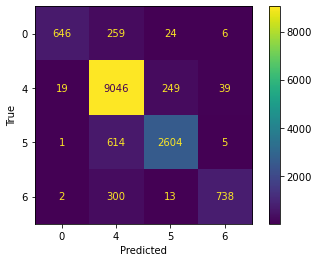

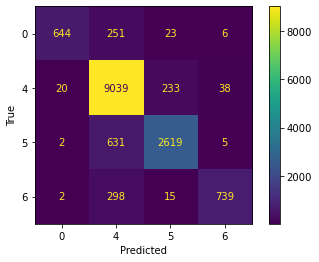

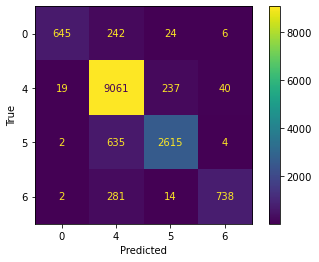

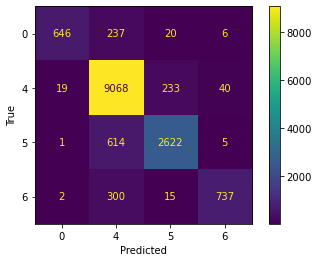

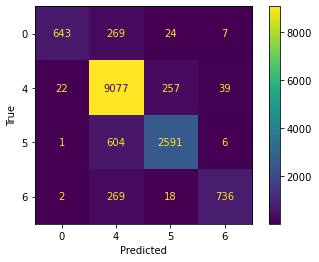

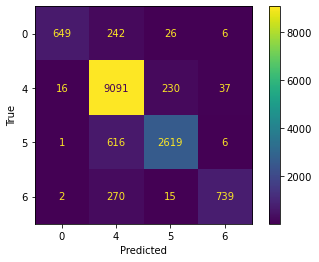

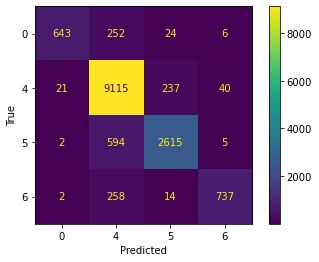

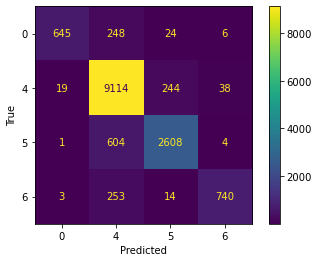

In [72]:
# Random Forests 
n=[100,200,300,400]             # no. of estimators (trees)
criterion=["gini", "entropy"]   #Information criterion
for i in criterion:
    for j in n:
        rf_clf = RandomForestClassifier(n_estimators=j, criterion=i)
        #Fitting the model
        rf_clf.fit(X_train, y_train)
        #predicting target variable for train and test data
        y_train_pred = rf_clf.predict(X_train)
        y_test_pred = rf_clf.predict(X_test)
        #Finding train and test accuracy
        accuracy1=accuracy_score(y_train, y_train_pred)
        accuracy2=accuracy_score(y_test, y_test_pred)
        print("For hyp(n={}, C={}) - Training accuracy of Random Forests: {}%\n Test Accuracy of Random Forests :{}%\n".format(j, i, accuracy1*100,accuracy2*100))
        print('Overall Model Evaluation:')
        evaluate(y_test_pred, y_test)